In this notebook we are going to define and train a CNN to classify Devanagari Handwritten Characters.


https://www.researchgate.net/publication/304406868_Deep_learning_based_large_scale_handwritten_Devanagari_character_recognition

#### DHCD Details
- Total Images: 92,000, Training(85%): 78,200 and Testing(15%): 13,800
- Each image is 32x32 pixels and the actual character is centered within 28x28 pixels.

We further divided the training set into training and validation set with the split of 90:10. If we desire, we can use the k-fold cross-validation scheme to train the model with entire 78,200 images instead of the 90%.

The model was trained with batch size of 16,32 and epoch 50, 70, 100 on all cases the average test accuracy was greater than 98%.

CNN Architecture






### Notebook Steps
- Loading necessary libraries
- Loading the data and data augmentation

#### Loading necessary libraries

In [0]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler
import torch.optim as optim

In [0]:
# This step downloads datasets from google drive to google colab.
# No need do on local machine.
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once in a notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
download = drive.CreateFile({'id': '1uDJ4UzNYiZlnpRIFHvamMWhOC_JAb_YW'})
download.GetContentFile('dhcd.zip')

In [0]:
#get_ipython().system_raw("unrar x full_data.rar")
!unzip dhcd.zip

Streaming output truncated to the last 5000 lines.
 extracting: dhcd/train/va/2702.png  
 extracting: dhcd/train/va/2704.png  
 extracting: dhcd/train/va/2705.png  
 extracting: dhcd/train/va/2706.png  
 extracting: dhcd/train/va/2707.png  
 extracting: dhcd/train/va/2710.png  
 extracting: dhcd/train/va/2711.png  
 extracting: dhcd/train/va/2713.png  
 extracting: dhcd/train/va/2715.png  
 extracting: dhcd/train/va/2716.png  
 extracting: dhcd/train/va/2717.png  
 extracting: dhcd/train/va/2719.png  
 extracting: dhcd/train/va/2720.png  
 extracting: dhcd/train/va/2721.png  
 extracting: dhcd/train/va/2722.png  
 extracting: dhcd/train/va/2723.png  
 extracting: dhcd/train/va/2724.png  
 extracting: dhcd/train/va/2725.png  
 extracting: dhcd/train/va/2726.png  
 extracting: dhcd/train/va/2727.png  
 extracting: dhcd/train/va/2729.png  
 extracting: dhcd/train/va/2730.png  
 extracting: dhcd/train/va/2731.png  
 extracting: dhcd/train/va/2732.png  
 extracting: dhcd/train/va/2733.png  

#### Loading the data and data augmentation

**Data Augmentation**
Our neural network is only as good the data we feed it. 

Most popular datasets have millions of images and most popular neural net architecture are trained with more than a millions of images or videos. We certainly can't be upset and sit down, what we can do is augment the datasets. 

We can randomly flip, rotate, introduce noise and apply a bunch of transforms so that our training set represent more general scenario than the data we have. By doing data augmentation we are increasing the capacity of our neural network to tune the parameters without increasing the data size.

**Training, Validating and Testing**

In this step, we will load the training and testing data. Further, we will divide the training data into validation and training sets. The validation set will be used to validate the hyperparameters we used and training set will be used to find the accuracy of the model. Right now, we are not going to use the K-fold cross validation, so choosing either 80:20 split or less than 20% for the validation set will be better.

**Normalize ?**

Normalize(mean=(0.5,), std=(0.5)) does the following for each channel:

$$image = {image - mean \over std}$$

With mean=0.5 and std-0.5, the image will be normalized the range [-1,1].

For example, the minimum value 0 will be converted to 

$${0 - 0.5 \over 0.5}=-1$$, the maximum value of 1 will be converted to $${1 - 0.5 \over 0.5}=1$$

To get our image back in [0,1] range, we could use,

$${ image = ((image * std) + mean)}$$

In [0]:
train_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=45, translate=(0.1, 0.1), scale=(0.8, 1.2)),
    transforms.RandomCrop(32),
    transforms.ToTensor(),
    transforms.Normalize((0.5, ), (0.5, ))
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, ), (0.5, ))
])

In [0]:
data_dir = "dhcd/"
train_data = datasets.ImageFolder(data_dir + "train/", transform = train_transform)
test_data = datasets.ImageFolder(data_dir + "test/", transform = test_transform)

output_size = len(train_data.classes)

Next, we will split the training set into training and validating set

In [0]:
batch_size = 32
valid_size = 0.10

num_train = len(train_data)
split_point = int(valid_size * num_train)

indices = list(range(num_train))
np.random.shuffle(indices)

valid_indices = indices[:split_point]
train_indices = indices[split_point:]

train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(valid_indices)

The loader combines a dataset and a sampler, and provides an iterable over the given dataset.

In [0]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

#### Visualizing a batch of training data



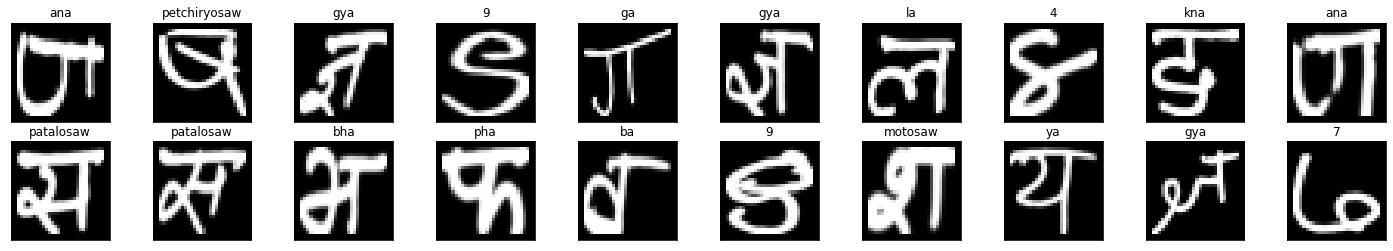

In [0]:
 # obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()


# plot the images in the batch, along with predicted labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    img = images.cpu()[idx]
    img = img * 0.5 + 0.5
    img = np.transpose(img, (1, 2, 0))
    plt.imshow(img)
    ax.set_title(test_data.classes[labels[idx].item()])


## CNN Architecture
In this step, we will define the network architecture.

**Maxpooling Layer?**
Most sucessfull network architecture use maxpooling to downsample, but research[] have shown that we can achieve same or better result without maxpooling as convolution downsample the image on its own.

In [0]:
def output(input_volume, kernel_size, padding, stride=1):
    return ((input_volume - kernel_size + 2 * padding)/stride) + 1

input_size = 32
print("Input image is of size: {}x{}".format(input_size, input_size))
print("First Conv sees: {}x{}".format(input_size, input_size))
input_size = output(input_volume=input_size, kernel_size=5, padding=0, stride=1)
print("Second Conv sees: {}x{}".format(input_size, input_size))
input_size = output(input_volume=input_size, kernel_size=5, padding=0, stride=1)
print("Third Conv sees: {}x{}".format(input_size, input_size))
input_size = output(input_volume=input_size, kernel_size=5, padding=0, stride=1)
print("Fourth Conv sees: {}x{}".format(input_size, input_size))

Input image is of size: 32x32
First Conv sees: 32x32
Second Conv sees: 28.0x28.0
Third Conv sees: 24.0x24.0
Fourth Conv sees: 20.0x20.0


In [0]:

class Network(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        # First layer sees: 32x32x3
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=0)
        
        # Second layer sees: 28x28x16
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=0)
        
        # Third layer sees: 24x24x32
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=0)
        
        # This layer output 20 x 20 x 64
        
        self.fc1 = nn.Linear(20*20*64, 1000)
        self.fc2 = nn.Linear(1000, output_size)
        self.dropout = nn.Dropout(p=0.25)
    
    def forward(self, x):
        
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        
        x = x.view(-1, 20*20*64)
        
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x
        

In [0]:
train_on_gpu = True if torch.cuda.is_available() else False

In [0]:
dhcd_model = Network()

if train_on_gpu:
  print("Training on GPU...")
  dhcd_model.cuda()

Training on GPU...


In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(dhcd_model.parameters(), lr=0.001, momentum=0.9)

In [0]:
n_epochs = 100
train_losses = []
valid_losses = []
valid_loss_min = np.inf

for e in range(n_epochs):
    train_loss = 0
    valid_loss = 0
    
    dhcd_model.train()
    
    for img, label in train_loader:
        
        if train_on_gpu:
            img = img.cuda()
            label = label.cuda()
        
        optimizer.zero_grad()
        
        predicted_label = dhcd_model(img)
        loss = criterion(predicted_label, label)
        loss.backward()
        optimizer.step()
        train_loss = train_loss + loss.item()
    
    dhcd_model.eval()
    
    for img, label in valid_loader:
        
        if train_on_gpu:
            img = img.cuda()
            label = label.cuda()
        predicted_label = dhcd_model(img)
        loss = criterion(predicted_label, label)
        
        valid_loss = valid_loss + loss.item()
    
    train_loss = train_loss/len(train_loader)
    train_losses.append(train_loss)
    valid_loss = valid_loss/len(valid_loader)
    valid_losses.append(valid_loss)
    
    print("Epoch: {} Train Loss: {} Valid Loss: {}".format(e+1, train_loss, valid_loss))
    
    if valid_loss < valid_loss_min:
        print("Validation Loss Decreased From {} to {}".format(valid_loss_min, valid_loss))
        valid_loss_min = valid_loss
        torch.save(dhcd_model.state_dict(), "dhcd_model_8_March_2020.pth")
        print("Saving Best Model")
    
        
    


Epoch: 1 Train Loss: 2.661668801226399 Valid Loss: 1.4674972694747301
Validation Loss Decreased From inf to 1.4674972694747301
Saving Best Model
Epoch: 2 Train Loss: 1.143354482285001 Valid Loss: 0.741693454737566
Validation Loss Decreased From 1.4674972694747301 to 0.741693454737566
Saving Best Model
Epoch: 3 Train Loss: 0.7248518495058471 Valid Loss: 0.5281538941422287
Validation Loss Decreased From 0.741693454737566 to 0.5281538941422287
Saving Best Model
Epoch: 4 Train Loss: 0.5521477951854468 Valid Loss: 0.4266203857198054
Validation Loss Decreased From 0.5281538941422287 to 0.4266203857198054
Saving Best Model
Epoch: 5 Train Loss: 0.45777393684468487 Valid Loss: 0.3696960729603865
Validation Loss Decreased From 0.4266203857198054 to 0.3696960729603865
Saving Best Model
Epoch: 6 Train Loss: 0.4040990167788484 Valid Loss: 0.3233884052354462
Validation Loss Decreased From 0.3696960729603865 to 0.3233884052354462
Saving Best Model
Epoch: 7 Train Loss: 0.36292828688567336 Valid Loss: 

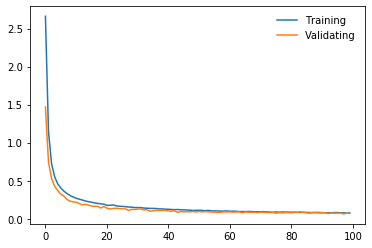

In [0]:
fig, axes = plt.subplots(nrows=1, ncols=1)
axes.plot(train_losses, label="Training")
axes.plot(valid_losses, label="Validating")
axes.legend(frameon=False)

### Testing the model

In [0]:
n_epochs = 50
avg_accuracy = 0
total_accuracy = 0
test_loss = 0
accuracy = 0
dhcd_model.eval()

for epoch in range(n_epochs):
    
    for img, label in test_loader:
        if train_on_gpu:
            img = img.cuda()
            label = label.cuda()
        predicted_label = dhcd_model(img)
        loss = criterion(predicted_label, label)
        test_loss = test_loss + loss.item()

        top_probab, top_label = predicted_label.topk(1, dim=1)
        equals = top_label == label.view(*top_label.shape)
        accuracy = accuracy + torch.mean(equals.type(torch.FloatTensor))

    test_loss = test_loss/len(test_loader)
    accuracy = accuracy/len(test_loader)
    total_accuracy = total_accuracy + accuracy

    print("Epoch: {} Test Loss: {} Accuracy: {}".format(epoch+1, test_loss, accuracy))

avg_accuracy = total_accuracy/(n_epochs) * 100
print("______________________\nAverage Accuracy: {:.3f}%\n______________________".format(avg_accuracy))

Epoch: 1 Test Loss: 0.03415448363456461 Accuracy: 0.9897280335426331
Epoch: 2 Test Loss: 0.03379959339197388 Accuracy: 0.9922360777854919
Epoch: 3 Test Loss: 0.03379469503945903 Accuracy: 0.9922419190406799
Epoch: 4 Test Loss: 0.0338258348196098 Accuracy: 0.9922419190406799
Epoch: 5 Test Loss: 0.03379127791457001 Accuracy: 0.9922419190406799
Epoch: 6 Test Loss: 0.033791039079495155 Accuracy: 0.9922419190406799
Epoch: 7 Test Loss: 0.03379103945795876 Accuracy: 0.9922419190406799
Epoch: 8 Test Loss: 0.03388512201025678 Accuracy: 0.9922419190406799
Epoch: 9 Test Loss: 0.03379125675961271 Accuracy: 0.9922419190406799
Epoch: 10 Test Loss: 0.03379296031450335 Accuracy: 0.9922419190406799
Epoch: 11 Test Loss: 0.03385906149729477 Accuracy: 0.9922419190406799
Epoch: 12 Test Loss: 0.033791996578416535 Accuracy: 0.9922419190406799
Epoch: 13 Test Loss: 0.03379101939163652 Accuracy: 0.9922419190406799
Epoch: 14 Test Loss: 0.0337911568625097 Accuracy: 0.9922419190406799
Epoch: 15 Test Loss: 0.033792

tensor([41,  1, 34, 21, 13, 38, 25, 40, 22,  6, 10, 12, 45,  1, 27, 41],
       device='cuda:0')
tensor([41,  1, 34, 21, 13, 38, 25, 40, 22,  6, 10, 12, 45,  1, 27, 41])


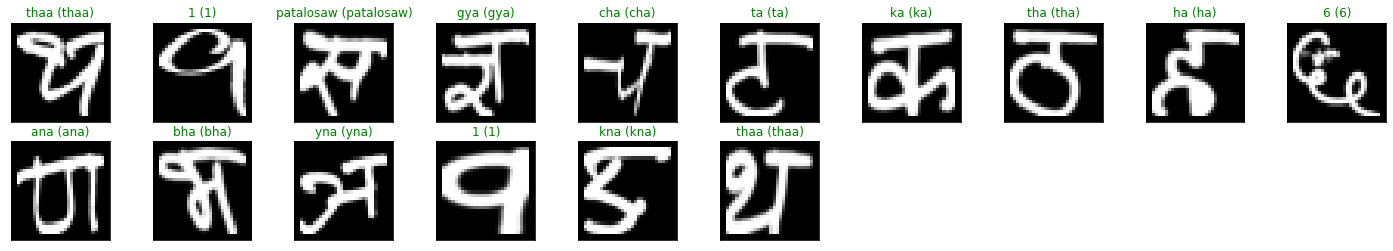

In [0]:
 # obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = dhcd_model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())



# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(16):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    img = images.cpu()[idx]
    img = img * 0.5 + 0.5
    img = np.transpose(img, (1, 2, 0))
    plt.imshow(img)
    ax.set_title("{} ({})".format(train_data.classes[preds[idx].item()], train_data.classes[labels[idx].item()]),
                 color=("green" if preds[idx]==labels[idx].item() else "red")) 
